In [1]:
import requests
import urllib.request
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
import datetime
googleApiKey = ''
hereApiKey = ''   

In [2]:
df = gpd.read_file('../../../Downloads/base/pompier.geojson')
#df = df.to_crs(4326)
df.index = 'zone_'+df.index.astype(str)


In [3]:
from time import sleep
def get_distance_matrix(origins,destinations=None,apiKey='',api='here',mode='car',time=None,buffer = 0.1):
    '''
    wrapper that return the time matrix (in seconds) for each OD
    with the Here matrix api or the google matrix api.

    parameters
    ----------
    origins (GeoDataframe) = geopandas dataframe with index and geometry (epsg:4326)
    
    destinations (None | GeoDataframe) = geopandas dataframe with index and geometry (epsg:4326)
    
    api (str) ='here', 'google'
    
    apiKey (str) : api key
    
    mode (str) = here : "car" "truck" "pedestrian" "bicycle" "taxi" "scooter" "bus" "privateBus".
    google : driving", "walking", "transit""bicycling"
    
    time (None|str) = here : Time of departure at all origins, in ISO 8601 format: the time zone offset is required.
    datetime.datetime.now().astimezone().isoformat() for example ('2022-11-16T11:19:21.944095-05:00')
    google : datetime.datetime() object. just in the future
    
    buffer (float) = here : 0.1 rad stating value, buffer will be increase (+0.1rad) while all origins & destinations are
    not included in the polygon around them. if it fail, you can provide a big buffer! (ex:1)

    returns
    ----------
    pd.dataframe index: origin, columns: destination. values: time in seconds
    ''' 
    if origins.crs != 'EPSG:4326':
        origins = origins.to_crs(4326)
    df=origins.copy()
    origins_index = df.index.values
    #format geometry to here api format
    origins = list(df['geometry'].apply(lambda p: {"lat":p.y, "lng":p.x}).values)
    # if destination, format them, else: use destination == origin
    if type(destinations) != type(None):
        if destinations.crs != 'EPSG:4326':
            destinations = destinations.to_crs(4326)
        df2=destinations.copy()
        destinations_index = df2.index.values
        destinations = list(df2['geometry'].apply(lambda p: {"lat":p.y, "lng":p.x}).values)
        df = pd.concat([df,df2])
    else:
        destinations = origins
        destinations_index = origins_index
    if api=='here':
        #get centroid for the here region
        centroid = LineString(df['geometry'].values).centroid
        #center = {"lat":centroid.y,"lng":centroid.x}
        #create a polygon around the points. find a buffer for the centroid that include every od

        while not centroid.buffer(buffer).contains(LineString(df['geometry'].values)):
            buffer+=0.1
        polygon = [{"lat":y,"lng":x} for x,y in list(zip(*centroid.buffer(buffer).exterior.coords.xy))[:-1]]

        region = {
            "type": "polygon",
            "outer": polygon,
            }
        #departureTime : Time of departure at all origins, in ISO 8601 (RFC 3339) 
        url = 'https://matrix.router.hereapi.com/v8/matrix?apiKey='+apiKey+'&async=false'
        body={
            "origins": origins,
            "destinations": destinations,
            "departureTime":time,
            'transportMode':mode,
            "regionDefinition": region
        }
        x = requests.post(url,json=body)
        resp = json.loads(x.text)
        if x.status_code !=200:
            raise Exception(resp)
        assert resp['matrix'].get('errorCodes') == None, 'try increasing buffer '+str(buffer) + 'was used in this attempt'
        #format response to a dataframa OD with time in secs.
        mat = np.array([time for time in resp['matrix']['travelTimes']]).reshape(len(origins),len(destinations))
        
    elif api == 'google':
        import googlemaps
        gmaps = googlemaps.Client(key=googleApiKey)
         
        mode = {'car':'driving','pedestrian':'walking','bicycle':'bicycling'}.get(mode,mode)
        res = gmaps.distance_matrix(origins = origins, 
                                    destinations = destinations, 
                                    departure_time = time, 
                                    mode = mode)
        if res['status'] != 'OK':
            raise Exception(res)
        mat=[]
        for i, origin in enumerate(res['rows']):
            for j, destination in enumerate(origin['elements']):
                mat.append((destination['duration']['value']))
        mat = np.array(mat).reshape(len(origins),len(destinations))
    else:
        raise Exception('api should be here or google.')
    
    od = pd.DataFrame(mat,index=origins_index,columns=destinations_index)
    od.index.name = 'origin'
    od.columns.name = 'destination'
    
    return od


def get_batches(df,max_od=15):
    '''
    gives index to divide dataframe into dataframes of length 15 max
    ex: [[0,15],[15,30],[30,35]] for a df of length 30.
    '''
    div = divmod(len(df),max_od)
    batches = [[max_od*i,max_od*(i+1)] for i in range(div[0])]
    if div[1]>0:
        if div[0]==0:
            batches.append([0,div[1]])
        else:
            batches.append([batches[-1][-1],batches[-1][-1]+div[1]])
    return batches


def multi_get_distance_matrix(origins,destinations,api='here',**kwargs):
    '''
    batch api call with 15x15 OD batches (limit per call for here)
    
    parameters
    ----------
    origins (GeoDataframe) = geopandas dataframe with index and geometry (epsg:4326)
    destination (GeoDataframe) = geopandas dataframe with index and geometry (epsg:4326)
    api (str) : 'here' or 'google'
    **kwargs: get_distance_matrix(origins, destinations, **kwargs)
    
    returns
    ----------
    pd.dataframe index: origin, columns: destination. values: time in seconds
    '''
    if api == 'here':
        max_od = 15
        assert len(origins)*len(destinations) <= 250_000, 'max 250 000 OD for free HERE api'

    elif api == 'google':
        max_od = 10
        assert len(origins)*len(destinations) <= 40_000, 'max 40 000 OD for free HERE api'
    else:
        raise Exception('api should be here or google')
    batches_origins = get_batches(origins, max_od)
    batches_destinations = get_batches(destinations, max_od)
    mat=pd.DataFrame()
    for batch_o in batches_origins:
        ori = origins.iloc[batch_o[0]:batch_o[1]]
        temp_mat=pd.DataFrame()
        for batch_o in batches_origins:
            des = destinations.iloc[batch_o[0]:batch_o[1]]
            try:
                res = get_distance_matrix(origins=ori,destinations=des,api=api,**kwargs)
            except:
                sleep(1)
                res = get_distance_matrix(origins=ori,destinations=des,api=api,**kwargs)
            temp_mat = pd.concat([temp_mat,res],axis=1)
            sleep(0.2)
        mat = pd.concat([mat,temp_mat],axis=0)
    return mat

# HERE simple call

In [5]:
res = get_distance_matrix(origins = df.iloc[0:2],
                          destinations=df.iloc[2:4],
                          apiKey=hereApiKey, 
                          api='here',
                          time='2022-11-16T08:30:00-05:00')
res

destination,zone_2,zone_3
origin,,
zone_0,246,676
zone_1,451,451


# Google simple call

In [8]:
res = get_distance_matrix(origins = df.iloc[0:2],destinations=df.iloc[2:4],apiKey=googleApiKey, api='google',time=datetime.datetime(2022,12,7,16,30))
res


 API queries_quota: 60 



destination,zone_2,zone_3
origin,,
zone_0,278,640
zone_1,535,453


In [17]:
import googlemaps
gmaps = googlemaps.Client(key=googleApiKey)
gmaps.distance_matrix


 API queries_quota: 60 



# Test API with more OD

In [5]:
links = gpd.read_file('../../../Downloads/S1/network/links.geojson')
links.index = 'link_'+links.index.astype(str)
#links

In [6]:
import random

In [7]:
nodes = gpd.read_file('../../../Downloads/S1/network/nodes.geojson')

In [8]:
set_nodes = nodes.loc[random.sample(range(0, len(nodes)), 20)]
set_nodes = set_nodes.set_index('ID')

<IPython.core.display.Javascript object>


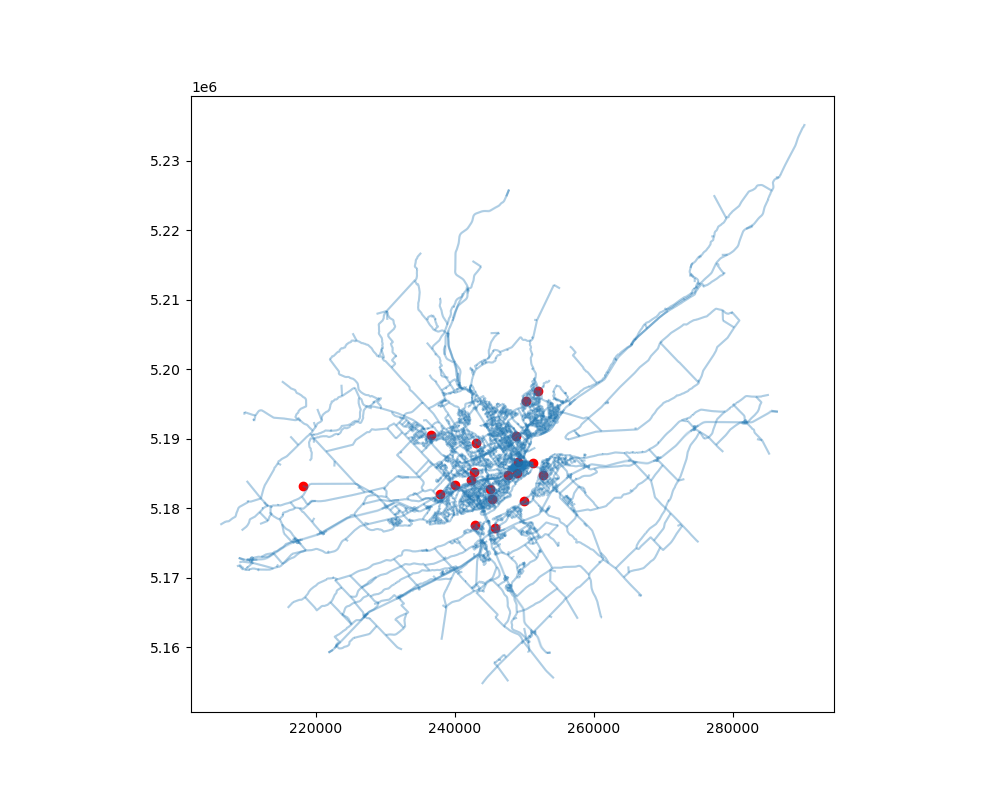

<AxesSubplot: >

In [9]:
%matplotlib notebook
f, ax = plt.subplots(figsize=(10,8))
links.plot(ax=ax,alpha=0.2)
set_nodes.plot(ax=ax,color='r')

In [10]:
import datetime
datetime.datetime.now().astimezone().isoformat()
'2022-11-16T11:19:21.944095-05:00'

'2022-11-16T11:19:21.944095-05:00'

In [11]:
od_time_here = multi_get_distance_matrix(origins = set_nodes, 
                                         destinations = set_nodes, 
                                         apiKey=hereApiKey, 
                                         api='here',
                                         time='2022-11-16T08:30:00-05:00')

In [12]:
od_time_here

destination,831,16056,30,30590,24446,30639,29083,590,7481,35979,3566,29326,33035,277,35975,998,35721,25428,11342,4246
origin,,,,,,,,,,,,,,,,,,,,
831,0,2002,1183,1955,1484,2444,1811,1495,940,479,583,1769,2193,439,331,993,756,2579,1728,1403
16056,1816,0,1405,1521,2406,2010,1377,2769,1590,1897,1469,1335,1759,1722,1846,1554,1671,2145,377,1227
30,1076,1458,0,1333,1353,1822,1189,1975,1175,1186,806,1147,1571,1016,1172,1197,666,1957,1184,462
30590,1901,1718,1502,0,2491,718,820,2854,1695,1982,1554,796,867,1807,1931,1659,1756,1296,1444,1333
24446,1391,2570,1405,2545,0,3034,2401,2044,1795,1255,1327,2359,2783,1516,1227,1857,1071,3169,2296,1752
30639,2213,2030,1814,665,2803,0,1132,3166,2007,2294,1866,1108,1179,2119,2243,1971,2068,1608,1756,1645
29083,1685,1502,1286,687,2275,1176,0,2638,1479,1766,1338,310,659,1591,1715,1443,1540,1111,1228,1117
590,1504,2988,2033,2941,2139,3430,2797,0,1988,1100,1723,2755,3179,1627,1173,2048,1424,3565,2714,2380
7481,948,1547,1126,1574,1768,2063,1430,1958,0,1129,631,1388,1812,776,981,53,1033,2198,1273,948


In [76]:
od_time_google = multi_get_distance_matrix(origins = set_nodes, destinations=set_nodes, apiKey=googleApiKey, api='google',)
od_time_google


 API queries_quota: 60 


 API queries_quota: 60 


 API queries_quota: 60 


 API queries_quota: 60 


 API queries_quota: 60 


 API queries_quota: 60 


 API queries_quota: 60 


 API queries_quota: 60 


 API queries_quota: 60 



destination,13139,3094,7521,491,705,31665,11369,28492,28501,13691,...,14485,24381,27556,17736,22839,14387,5510,5358,12394,2634
origin,,,,,,,,,,,,,,,,,,,,,
13139,0,500,834,890,1375,1868,1380,874,842,950,...,861,1320,921,2759,2278,706,910,761,703,803
3094,487,0,964,1141,1737,2229,1742,945,914,1311,...,1222,1450,1096,2889,2639,1068,1271,1122,1065,1166
7521,955,1029,0,303,1526,2019,1515,927,896,1085,...,1009,1776,1377,3215,2430,833,1087,895,1247,1257
491,1125,1200,306,0,1534,2027,1562,1197,1165,1131,...,1019,1823,1424,3262,2403,865,1068,942,1294,1304
705,1358,1552,1475,1400,0,1262,1439,1718,1687,870,...,614,2162,1763,3601,2337,778,511,831,1535,1355
31665,1889,2083,2006,1931,1125,0,1956,2249,2218,1356,...,1131,2693,2294,4132,2854,1309,1183,1380,2066,1886
11369,1452,1645,1525,1494,1433,1925,0,1812,1781,1212,...,817,2255,1856,3694,1467,872,999,1144,1598,1418
28492,1012,1034,976,1240,1911,2403,1916,0,63,1485,...,1396,1913,1514,3352,2813,1242,1445,1296,1348,1358
28501,963,985,927,1190,1861,2354,1866,77,0,1436,...,1346,1864,1465,3303,2764,1192,1395,1246,1298,1309


# OD on road model

In [10]:
from quetzal.engine.road_pathfinder import sparse_matrix, parallel_dijkstra
from scipy.sparse.csgraph import dijkstra


In [11]:
links['time'] = links['length']/links['speedau']
links['time'] = links['time']*3600

In [12]:
mat,indices = sparse_matrix(links[['i','j','time']].values)


In [13]:
def road_routing(origin,destination,mat,node_index,dijkstra_limit=np.inf):
    # simple routing scipy wrapper for GTFS routing
    #
    index_node = {v: k for k, v in node_index.items()}
    # liste des origines pour le dijkstra
    origin_sparse = [node_index[x] for x in origin]
    
    # dijktra on the road network from node = incices to every other nodes.
    # from b to a.
    dist_matrix, predecessors = dijkstra(
        csgraph=mat,
        directed=True,
        indices=origin_sparse,
        return_predecessors=True,
        limit=dijkstra_limit
    )

    dist_matrix = pd.DataFrame(dist_matrix)
    dist_matrix.index = origin
    # filtrer. on garde seulement les destination d'intéret
    destination_sparse = [node_index[x] for x in destination]
    dist_matrix = dist_matrix[destination_sparse]
    dist_matrix = dist_matrix.rename(columns=index_node)
    
    return dist_matrix

In [14]:
od_time_quebec = road_routing(set_nodes.index.values,
             set_nodes.index.values,
             mat,
             indices)

In [15]:
od_time_here.mean().mean()/60

NameError: name 'od_time_here' is not defined

In [19]:
od_time_quebec.mean().mean()/60

18.707888443663766

In [885]:
print('erreur moyenne')
round(100*(abs(od_time_here-od_time_quebec)/od_time_quebec).mean().mean(),1)

erreur moyenne


14.7

In [886]:
round(100*(abs(od_time_here-od_time_quebec)/od_time_quebec).mean().mean(),1)

14.7

In [887]:
od_time_here

destination,3902,14961,29183,3048,4218,13646,14934,32275,9269,18848,769,3775,12198,32107,1702,3183,12146,4594,5992,13350,2468,10501,33785,28593,5088,6571,2539,29812,26635,6795
origin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3902,0,1104,1064,977,587,887,1020,1362,910,2041,2119,211,752,1309,806,834,606,674,695,226,427,805,1628,1411,316,667,294,1531,1181,911
14961,1062,0,1743,1122,1526,1589,317,2041,1550,2720,2798,986,1280,1837,1192,1181,1134,939,638,1165,1156,1558,2307,1606,1361,1387,1233,2210,648,1642
29183,1191,1855,0,1598,884,698,1771,547,840,1295,1373,1161,1373,1930,1427,1518,1227,1425,1446,1025,1257,784,671,2032,1046,674,1145,574,1932,590
3048,968,1164,1615,0,1410,1491,1080,1913,1422,2592,2670,923,728,1285,167,198,582,315,721,1071,1067,1460,2179,1039,1212,1322,1139,2082,1234,1566
4218,615,1518,702,1261,0,351,1434,1000,829,1679,1757,656,969,1366,1090,1181,890,1088,1109,491,650,754,1266,1695,621,616,569,1169,1595,579
13646,792,1483,630,1226,402,0,1399,928,757,1607,1685,789,1001,1646,1055,1146,855,1053,1074,791,930,701,1194,1660,586,619,869,1097,1560,507
14934,981,300,1662,1041,1445,1508,0,1960,1469,2639,2717,905,1199,1756,1111,1100,1053,858,606,1084,1075,1477,2226,1525,1280,1306,1152,2129,331,1561
32275,1543,2207,632,1950,1236,1050,2123,0,1192,1554,1632,1513,1725,2282,1779,1870,1579,1777,1798,1377,1609,1136,567,2384,1398,1026,1497,245,2284,942
9269,999,1715,728,1426,856,792,1599,1026,0,1705,1783,1048,1201,1758,1255,1346,1055,1253,1274,853,1085,429,1292,1860,874,574,973,1195,1760,448


In [48]:
print('erreur moyenne')
round(100*(abs(od_time_here-od_time_google)/od_time_google).mean().mean(),1)

erreur moyenne


6.1

In [49]:
od_time_here.mean().mean()/60

24.456944444444442

In [80]:
od_time_google.mean().mean()/60